In [ ]:
# Crear carpeta destino
!mkdir -p dataset

# Descargar el archivo zip del set de entrenamiento (13GB)
!wget -c http://images.cocodataset.org/zips/train2014.zip -P dataset/

# Descomprimir dentro de la carpeta dataset/
!unzip -q dataset/train2014.zip -d dataset/


--2025-06-14 23:26:28--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.2.135, 3.5.28.205, 16.15.201.127, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.2.135|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace dataset/train2014/COCO_train2014_000000270070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Información de esta red

Esta red es del tipo "feedforward" y básicamente significa que la imagen de entrada pasa por la red (sin ciclos ni cosas raras) y te da la imagen generada con el estilo aplicado.

## Entrenamiento

En el entrenamiento, para obtener el style-loss y el content-loss se pasan ambas por una VGG-16 pre-entrenada para obtener las feature maps.

Se genera una imagen con la red TransformerNetwork y se la pasa por la VGG-16 también.

**Para el style-loss**: Se hace un MSELoss con las fmaps obtenidas en la VGG-16 con la imagen de estilos (transformandolas en una matriz gram) con la matriz gram de la imagen generada.

**Para el content_loss**: Se hace un MSELoss con las fmaps obtenidas en la VGG-16 con la imagen de contenidos y las fmaps de la imagen generada

Para el total loss: **style_loss + content_loss**

En base a eso se calculan las gradientes y se optimizan los parámetros de la red TransformerNetwork (que genera la imagen).

## Finalmente

Al entrenar la red TransformerNetwork, esta será capaz de generar imágenes con un estilo determinado. Por eso es que hay que entrenar a la red con distintas imágenes y obtener los pesos .pth.

Básicamente se hace lo que la imagen de abajo, pero la imagen no es el parámetro a optimizar, sino los propios parámetros de la red que generan la imagen nueva. No se parte de una imagen con ruido, sino que durante el entrenamiento se le pasa la imagen de contenido.

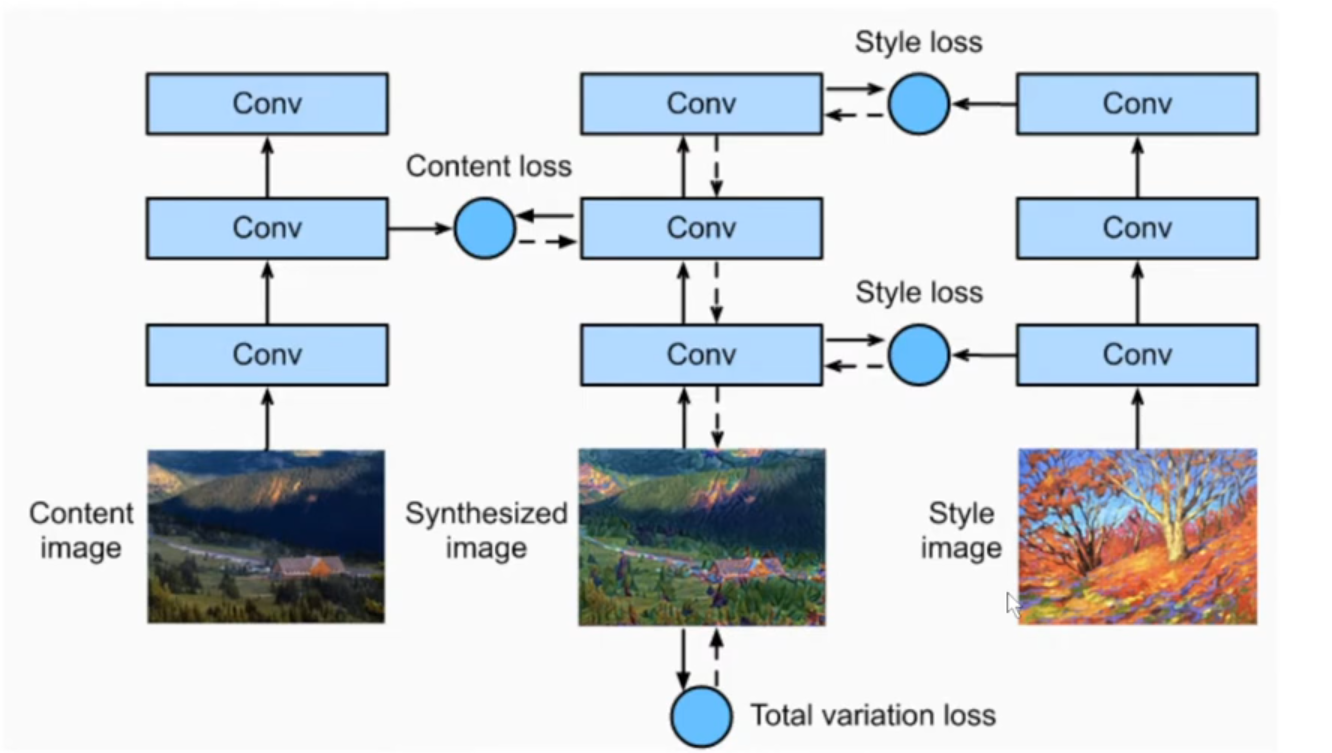

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets

# Gram Matrix
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(B, C, H*W)
    x_t = x.transpose(1, 2)
    return  torch.bmm(x, x_t) / (C*H*W)

# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

def saveimg(img, image_path):
    img = img.clip(0, 255)
    cv2.imwrite(image_path, img)

# Preprocessing ~ Image to Tensor
def itot(img, max_size=None):
    # Rescale the image
    if (max_size==None):
        itot_t = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])
    else:
        H, W, C = img.shape
        image_size = tuple([int((float(max_size) / max([H,W]))*x) for x in [H, W]])
        itot_t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.mul(255))
        ])

    # Convert image to tensor
    tensor = itot_t(img)

    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

# Preprocessing ~ Tensor to Image
def ttoi(tensor):
    # Add the means
    #ttoi_t = transforms.Compose([
    #    transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    #img = ttoi_t(tensor)
    img = tensor.cpu().numpy()

    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

def transfer_color(src, dest):
    """
    Transfer Color using YIQ colorspace. Useful in preserving colors in style transfer.
    This method assumes inputs of shape [Height, Width, Channel] in BGR Color Space
    """
    src, dest = src.clip(0,255), dest.clip(0,255)

    # Resize src to dest's size
    H,W,_ = src.shape
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr

    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR).clip(0,255)  #4 Convert new image from YIQ back to BGR

def plot_loss_hist(c_loss, s_loss, total_loss, title="Loss History"):
    x = [i for i in range(len(total_loss))]
    plt.figure(figsize=[10, 6])
    plt.plot(x, c_loss, label="Content Loss")
    plt.plot(x, s_loss, label="Style Loss")
    plt.plot(x, total_loss, label="Total Loss")

    plt.legend()
    plt.xlabel('Every 500 iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths.
    Extends torchvision.datasets.ImageFolder()
    Reference: https://discuss.pytorch.org/t/dataloader-filenames-in-each-batch/4212/2
    """
    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)

        # the image file path
        path = self.imgs[index][0]

        # make a new tuple that includes original and the path
        tuple_with_path = (*original_tuple, path)
        return tuple_with_path

In [ ]:
import torch
import torch.nn as nn

class TransformerNetwork(nn.Module):
    """Feedforward Transformation Network without Tanh
    reference: https://arxiv.org/abs/1603.08155
    exact architecture: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    """
    def __init__(self):
        super(TransformerNetwork, self).__init__()
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU()
        )
        self.ResidualBlock = nn.Sequential(
            ResidualLayer(128, 3),
            ResidualLayer(128, 3),
            ResidualLayer(128, 3),
            ResidualLayer(128, 3),
            ResidualLayer(128, 3)
        )
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm="None")
        )

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        out = self.DeconvBlock(x)
        return out

class TransformerNetworkTanh(TransformerNetwork):
    """A modification of the transformation network that uses Tanh function as output
    This follows more closely the architecture outlined in the original paper's supplementary material
    his model produces darker images and provides retro styling effect
    Reference: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    """
    # override __init__ method
    def __init__(self, tanh_multiplier=150):
        super(TransformerNetworkTanh, self).__init__()
        # Add a Tanh layer before output
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm="None"),
            nn.Tanh()
        )
        self.tanh_multiplier = tanh_multiplier

    # Override forward method
    def forward(self, x):
        return super(TransformerNetworkTanh, self).forward(x) * self.tanh_multiplier

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm="instance"):
        super(ConvLayer, self).__init__()
        # Padding Layers
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        # Convolution Layer
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualLayer(nn.Module):
    """
    Deep Residual Learning for Image Recognition

    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, channels=128, kernel_size=3):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride=1)

    def forward(self, x):
        identity = x                     # preserve residual
        out = self.relu(self.conv1(x))   # 1st conv layer + activation
        out = self.conv2(out)            # 2nd conv layer
        out = out + identity             # add residual
        return out

class DeconvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm="instance"):
        super(DeconvLayer, self).__init__()

        # Transposed Convolution
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

In [ ]:
!mkdir -p models
!mkdir -p images
!mkdir -p images/out

In [ ]:
!wget -P models https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

--2025-06-14 23:26:39--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘models/vgg16-00b39a1b.pth.2’

vgg16-00b39a1b.pth. 100%[===================>] 527.81M  59.2MB/s    in 9.2s    

2025-06-14 23:26:48 (57.3 MB/s) - ‘models/vgg16-00b39a1b.pth.2’ saved [553451520/553451520]



In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms

class VGG19(nn.Module):
    def __init__(self, vgg_path="models/vgg19-d01eb7cb.pth"):
        super(VGG19, self).__init__()

        # Load VGG Skeleton, Pretrained Weights
        vgg19_features = models.vgg19(pretrained=False)
        vgg19_features.load_state_dict(torch.load(vgg_path), strict=False)
        self.features = vgg19_features.features

        # Turn-off Gradient History
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        layers = {'3': 'relu1_2', '8': 'relu2_2', '17': 'relu3_4', '22': 'relu4_2', '26': 'relu4_4', '35': 'relu5_4'}
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x

        return features

class VGG16(nn.Module):
    def __init__(self, vgg_path="models/vgg16-00b39a1b.pth"):
        super(VGG16, self).__init__()

        # Load VGG Skeleton, Pretrained Weights
        vgg16_features = models.vgg16(pretrained=False)
        vgg16_features.load_state_dict(torch.load(vgg_path, weights_only=False), strict=False)
        self.features = vgg16_features.features

        # Turn-off Gradient History
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        layers = {'3': 'relu1_2', '8': 'relu2_2', '15': 'relu3_3', '22': 'relu4_3'}
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
                if (name=='22'):
                    break

        return features

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import time

# GLOBAL SETTINGS
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "dataset"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "vangogh.jpg"
BATCH_SIZE = 4
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "models/"
SAVE_IMAGE_PATH = "images/out/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

def train():
    # Seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Load networks
    transformerNetwork = TransformerNetwork().to(device)

    # state_dict_transformer = torch.load("models/last_fuego.pth", map_location=device)
    # transformerNetwork.load_state_dict(state_dict_transformer)
    VGG = VGG16().to(device)

    # Get Style Features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)

    style_image = load_image(STYLE_IMAGE_PATH)
    style_tensor = itot(style_image).to(device) # Transformación a tensor
    style_tensor = style_tensor.add(imagenet_neg_mean) # Normalización de la imagen

    # Pasamos la imagen de estilos por la VGG y obtenemos los fmaps
    B, C, H, W = style_tensor.shape
    style_features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))

    # Calculamos matriz de gram de cada capa de la VGG para calcular el style-loss (despues)
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = gram(value)

    # Optimizer settings
    optimizer = optim.Adam(transformerNetwork.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # Free-up unneeded cuda memory
            torch.cuda.empty_cache()

            # Zero-out Gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device) # Pasa de RGB a BGR por la red VGG
            generated_batch = transformerNetwork(content_batch) # Pasa las imágenes de contenido por la red Transformer

            # Obtenemos features con las imágenes de contenido y las generadas
            content_features = VGG(content_batch.add(imagenet_neg_mean))
            generated_features = VGG(generated_batch.add(imagenet_neg_mean))

            # Content Loss - MSE directo con las fmaps de contenidos y las generadas
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu2_2'], content_features['relu2_2'])
            batch_content_loss_sum += content_loss

            # Style Loss - MSE con las matrices gram de las imagenes generadas con Transformer y las gram de la imagen de estilos
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Total Loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backprop and Weight Update
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(transformerNetwork.state_dict(), checkpoint_path)
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
                sample_image = ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                saveimg(sample_image, sample_image_path)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)

            # Iterate Batch Counter
            batch_count+=1

    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history)
    print("========Style Loss========")
    print(style_loss_history)
    print("========Total Loss========")
    print(total_loss_history)

    # Save TransformerNetwork weights
    transformerNetwork.eval()
    transformerNetwork.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(transformerNetwork.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)

train()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


========Epoch 1/1========
========Iteration 1/20696========
	Content Loss:	2917066.00
	Style Loss:	120623824.00
	Total Loss:	123540888.00
Time elapsed:	0.44584107398986816 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_0.pth
Saved sample tranformed image at images/out/sample0_0.png
========Iteration 501/20696========
	Content Loss:	5503370.50
	Style Loss:	16837663.71
	Total Loss:	22341035.82
Time elapsed:	123.61510992050171 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_500.pth
Saved sample tranformed image at images/out/sample0_500.png
========Iteration 1001/20696========
	Content Loss:	5272882.00
	Style Loss:	9480502.80
	Total Loss:	14753384.97
Time elapsed:	306.64719581604004 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_1000.pth
Saved sample tranformed image at images/out/sample0_1000.png
